<img src="https://i.ibb.co/jGWqPCJ/banner.png">

# Predict Wind Speeds of Tropical Storms

__Team:__ ______ <br>
__Elements:__   Francisco Costa, João Gouveia, Pedro Rivera

<a class="anchor" id="Table_Contents"></a>
__Table of Contents:__ <br>
* [1. Business Understanding](#business-understanding)
* [2. Data Understanding](#data-understanding)
* [3. Data Preparation](#data-preparation)
* [4. Modeling](#modeling)
* [5. Submission](#submission)

<a class="anchor" id="business-understanding"></a>
## 1. Imports & Configs

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import re
from sklearn import metrics

#SEABORN SETTINGS
sns.set_style('darkgrid')

#PANDAS SETTINGS
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

jump_cell = True

In [2]:
selected_device = '/GPU:0'

# with tf.device(selected_device_in):

In [3]:
# general definitions
batch_size = 256
img_width = 32
img_height = 32

In [4]:
training_dir = '../image_data/train'
test_dir = '../image_data/test'

<a class="anchor" id="data-understanding"></a>
## 2. Data Understanding

### 2.1 Features

In [5]:
train_features = pd.read_csv('data/training_set_features.csv')
train_features.head(8)

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2
5,abs_005,abs,32399,2
6,abs_006,abs,34199,2
7,abs_007,abs,37799,2


In [6]:
print('There are {} storms in this training dataset.'.format(train_features['storm_id'].nunique()))

There are 494 storms in this training dataset.


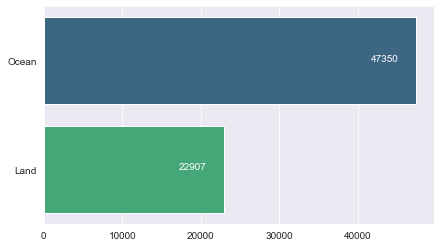

In [7]:
fig, ax = plt.subplots(figsize=(7,4))

ocean_values = train_features['ocean'].value_counts().values

sns.barplot(x=ocean_values,
            y=['Ocean', 'Land'],
            orient='h',
            palette='viridis',
            ax=ax)

for idx, val in enumerate(ocean_values):
    ax.text(x = val - ocean_values.min()*0.25,
            y = idx,
            s = val,
            **dict(size=10, color='white'))
    
plt.show()

### 2.2 Labels

In [8]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


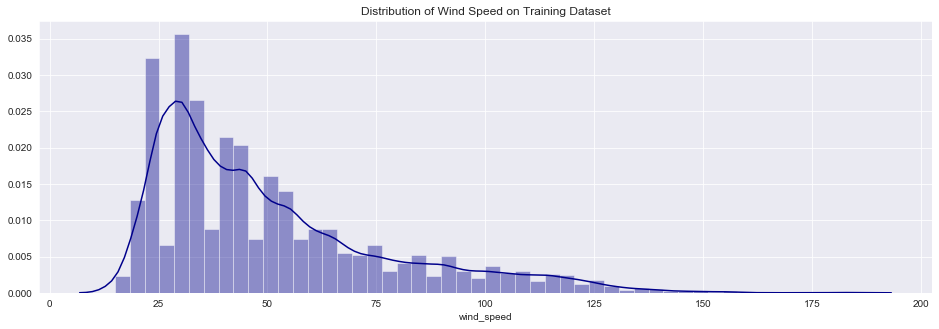

In [9]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Distribution of Wind Speed on Training Dataset')
sns.distplot(a=train_labels['wind_speed'],color='darkblue')

plt.show()

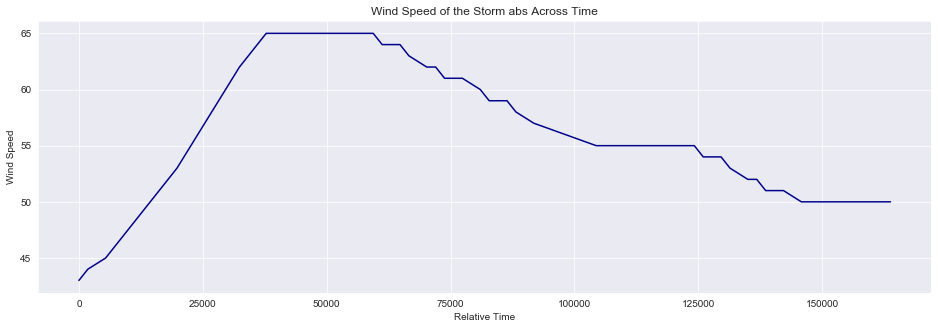

In [10]:
storm_choice = 'abs'

fig, ax = plt.subplots(figsize=(16,5))

time = train_features.loc[train_features['storm_id']==storm_choice]['relative_time'].values
speed = train_labels.loc[train_labels['image_id'].str.contains(storm_choice)]['wind_speed'].values

plt.title('Wind Speed of the Storm {} Across Time'.format(storm_choice))
plt.ylabel('Wind Speed')
plt.xlabel('Relative Time')
sns.lineplot(x=time, y=speed, color='darkblue')

plt.show()


### 2.3 Images

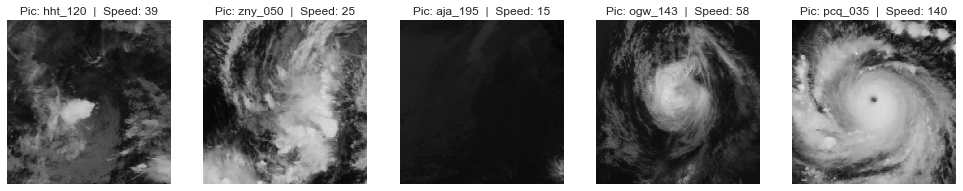

In [11]:
sample_images = []
train_imgs = [file for file in os.listdir(training_dir)]

for idx in np.random.randint(0,len(train_imgs),5):
    sample_images.append(training_dir+'/'+train_imgs[idx])

fig, axes = plt.subplots(1, 5, figsize=(17,8))

for idx,img in enumerate(sample_images):
    image = cv2.imread(img)
    name = img.split('/')[-1][:-4]
    wind_s = train_labels.loc[train_labels['image_id']==name]['wind_speed'].values[0]
    axes[idx].set_title('Pic: {}  |  Speed: {}'.format(name,wind_s))
    axes[idx].imshow(image)
    axes[idx].axis("off")

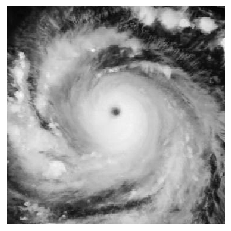

In [12]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image2, cmap='gray')
plt.axis("off")
plt.show()

In [13]:
image2.shape

(366, 366)

In [14]:
for dim in range(0,image.shape[2]):
    print('Dimension {}: the maximum is {} and the minimum is {}.'.format(dim, image[dim].max(), image[dim].min()))

Dimension 0: the maximum is 181 and the minimum is 3.
Dimension 1: the maximum is 181 and the minimum is 3.
Dimension 2: the maximum is 187 and the minimum is 5.


In [15]:
if jump_cell == False:
    
    storm_choice = 'rkw'

    img_array = []
    for file in os.listdir(training_dir):
        if storm_choice in file:
            img = cv2.imread(training_dir + '/' + file)
            height, width, layers = img.shape
            size = (width,height)
            img_array.append(img)

    out = cv2.VideoWriter('storm_example.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [16]:
if jump_cell == False:
    
    cap = cv2.VideoCapture('storm_example.avi')

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print("Stream ended")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('Storm {}'.format(storm_choice), gray)

        if cv2.waitKey(50) & 0xff==27:
            break

    cap.release()
    cv2.destroyAllWindows()

<a class="anchor" id="data-preparation"></a>
## 3. Data Preparation

In [17]:
df_train = pd.merge(train_features, train_labels, how='inner', on='image_id')

In [18]:
df_train['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(df_train['image_id'])

In [19]:
df_train.head()

,image_id,storm_id,relative_time,ocean,wind_speed,image_id_jpg
0,abs_000,abs,0,2,43,abs_000.jpg
1,abs_001,abs,1800,2,44,abs_001.jpg
2,abs_002,abs,5400,2,45,abs_002.jpg
3,abs_003,abs,17999,2,52,abs_003.jpg
4,abs_004,abs,19799,2,53,abs_004.jpg


<a class="anchor" id="modeling"></a>
## 4. Modeling

In [20]:
def split_train_val_test(df):
    train, validate, test = np.split(df.sample(frac=1, random_state=42),
                                 [int(.7*len(df)), int(.85*len(df))])
    return train, validate, test

In [21]:
df_train_train, df_train_val, df_train_test = \
            split_train_val_test(df_train)

In [22]:
datagen = ImageDataGenerator(rescale=1./255)

print('Training Set:')
train_generator = datagen.flow_from_dataframe(dataframe = df_train_train,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)
print()

print('Validation Set:')
val_generator = datagen.flow_from_dataframe(dataframe = df_train_val,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)
print()

print('Test Set:')
test_generator = datagen.flow_from_dataframe(dataframe = df_train_test,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)

Training Set:
Found 49179 validated image filenames.

Validation Set:
Found 10539 validated image filenames.

Test Set:
Found 10539 validated image filenames.


In [133]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, TimeDistributed, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

In [142]:
input_shape = (32, 32 , 32, 3)

model = Sequential()

# define CNN model
model.add(TimeDistributed(Conv2D(16, kernel_size=3, activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(2)))
model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.1)))
model.add(TimeDistributed(Flatten()))

#model.add(Reshape((1,)+input_shape))
          
# define LSTM model
model.add(LSTM(3, return_sequences=True, input_shape=(None, None, 32, 8192)))
model.add(Dense(64, activation = "relu"))        
model.add(Dense(32, activation = "relu"))
model.add(Dense(16, activation = "relu")) 
model.add(Dense(1, activation='relu'))


#Compiler
model.compile(optimizer=Adam(lr=0.0001), loss='mse')

In [143]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_170 (TimeDi (None, 32, 32, 32, 16)    448       
_________________________________________________________________
time_distributed_171 (TimeDi (None, 32, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_172 (TimeDi (None, 32, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_173 (TimeDi (None, 32, 16, 16, 32)    0         
_________________________________________________________________
time_distributed_174 (TimeDi (None, 32, 8192)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32, 3)             98352     
_________________________________________________________________
dense_84 (Dense)             (None, 32, 64)          

In [131]:
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                          verbose=1, patience=25)

In [144]:
with tensorflow.device(selected_device):
    model.fit_generator(generator = train_generator,
                        epochs = 20,
                        steps_per_epoch = 20,
                        validation_data = val_generator,
                        validation_steps=5,
                        callbacks=[early_stop])

Epoch 1/20


ValueError: Error when checking input: expected time_distributed_170_input to have 5 dimensions, but got array with shape (32, 32, 32, 3)

In [ ]:
ws_test_true = df_train_test['wind_speed'].values

ws_test_preds = model.predict_generator(test_generator)
ws_test_preds = ws_test_preds.reshape(-1)

In [ ]:
losses = pd.DataFrame(model.history.history)

fig, axes = plt.subplots(figsize=(12,5))

sns.lineplot(x=losses.index,
             y='loss',
             data = losses,
             ax=axes,
             color='darkblue',
             label='Training Loss')

sns.lineplot(x=losses.index,
             y='val_loss',
             data = losses,
             ax=axes,
             color='orange',
             label='Validation Loss')

plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))

sns.scatterplot(x=ws_test_true,
               y=ws_test_preds, ax=axes,
               color='darkblue')
sns.lineplot(x=ws_test_true,
             y=ws_test_true,
             ax=axes,
            color='orange',
            linewidth = 3)

plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')

plt.show()

In [ ]:
print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))

<a class="anchor" id="submission"></a>
## 5. Submission

In [ ]:
df_sub = pd.read_csv('data/test_set_features.csv')

df_sub['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(df_sub['image_id'])

df_sub = append_prev_img(df_sub, 'image_id')

In [ ]:
if os.path.isdir('../image_data/new_test'):
    pass
else:
    os.mkdir('../image_data/new_test')

In [ ]:
if jump_cell == False:
    for image_current, image_prev in zip(df_sub['image_id'].values, df_sub['prev_image_id'].values):
        opticalFlowDense([image_current, image_prev], test_dir +'/', '../image_data/new_test/')

In [ ]:
print('Submission Set:')
submission_generator = datagen.flow_from_dataframe(dataframe = df_sub,
                                              directory = "../image_data/new_test",
                                              x_col = "image_id_jpg",
                                              y_col = None,
                                              class_mode = None,
                                              target_size = (32,32),
                                              batch_size = 32)

In [ ]:
with tensorflow.device(selected_device):
    ws_sub_preds = model.predict_generator(submission_generator)
    ws_sub_preds = ws_sub_preds.reshape(-1)

In [ ]:
df_sub['wind_speed'] = ws_sub_preds
df_sub['wind_speed'] = np.vectorize(lambda ws: int(ws))(df_sub['wind_speed'])

In [ ]:
mov_avg_ison = True

In [ ]:
if mov_avg_ison == False:
    
    df_to_sub = df_sub[['image_id','wind_speed']]
    df_to_sub.set_index('image_id', inplace=True)
    
else:
    
    series_mov_avg = []

    for storm in df_sub['storm_id'].unique():
        lista = df_sub[df_sub['storm_id']==storm]['wind_speed'].rolling(window=5, center=True).mean()
        series_mov_avg.append(lista)

    series_mov_avg_flat = [item for sublist in series_mov_avg for item in sublist]

    df_sub['mov_avg'] = series_mov_avg_flat
    df_sub['mov_avg'].fillna(df_sub['wind_speed'], inplace=True)
    df_sub['mov_avg'] = np.vectorize(lambda ws: int(ws))(df_sub['mov_avg'])
    
    df_to_sub = df_sub[['image_id','mov_avg']]
    df_to_sub.set_index('image_id', inplace=True)
    df_to_sub.rename(columns={'mov_avg':'wind_speed'}, inplace=True)

In [ ]:
now = datetime.now().strftime("%Y%m%d_%H%M")
df_to_sub.to_csv('submissions/dfsub_'+now+'.csv')

model.save('models/model_'+now+'.h5')

print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))